# Load Packages

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from os.path import basename

In [139]:
def x_digit(x):
    if int(x)<10:
        x = '0'+str(x)
    else:
        x = str(x)
    return x

# Data Wrangling & QC

In [184]:
def read_data(files, header):
    import numpy as np
    import pandas as pd
    quantities = ['Temperature', 'Rel. Humidity', 'Pressure', 'CO', r'CO$_2$', r'NH$_3$', r'PM$_{1}$', 
                  'PM$_{2.5}$', 'PM$_{10}$']
    units = [r'$^o$C','%', 'hPa','ppm','ppm','ppm',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ',r'$\mu$g m$^3$ ']


    header = pd.read_csv(header, header=None)
    if np.size(files) == 1:
        out = pd.read_csv(files, header=None)
    else:
        out = pd.DataFrame()
        for f in files:
            df = pd.read_csv(f, header=None)
            out = pd.concat([out,df], axis=0)
    out.columns = list(header.values[0])
    dates = [d.split('-')[0]+'-'+x_digit(int(d.split('-')[1]))+'-'+x_digit(int(d.split('-')[2].split(' ')[0]))+' '+d.split('-')[2].split(' ')[1] for d in out.Datetime]
    out['Datetime'] = pd.to_datetime(dates, format='%Y-%m-%d %H:%M:%S')
    out = out.set_index('Datetime').drop(['Altitude'], axis=1)[2:]
    out['Pressure'] = out['Pressure']/100
            
    return out

In [189]:
quantities = ['Temperature', 'Rel. Humidity', 'Pressure', 'CO', r'CO$_2$', r'NH$_3$', r'PM$_{1}$', 
              'PM$_{2.5}$', 'PM$_{10}$']
units = [r'$^o$C','%', 'hPa','ppm','ppm','ppm',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ',r'$\mu$g m$^3$ ']

path = os.getcwd().replace('\\','/')
df = read_data(sorted(glob.glob(path+'/Data/datalog*.csv')),   'Data/header.txt')


# Visualization

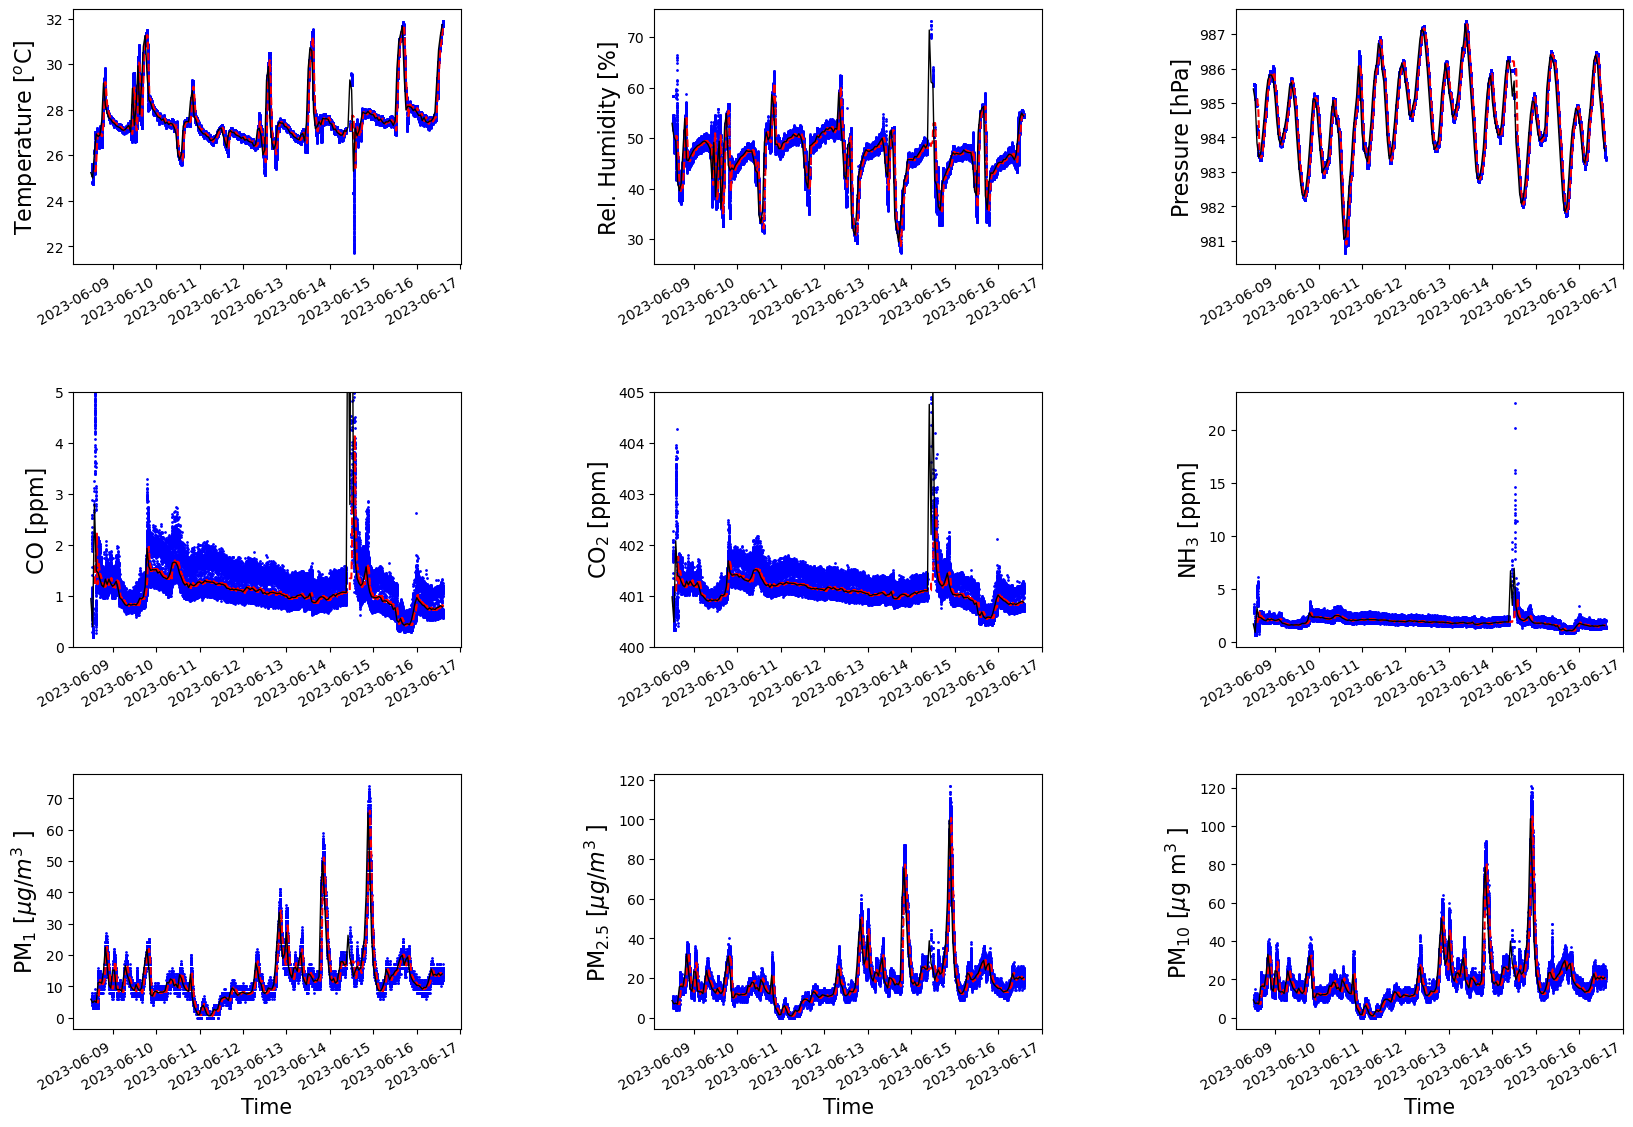

In [190]:
cs = 3
rs = len(df.columns)//cs if len(df.columns)%cs==0 else (len(df.columns)//cs)+1 
fig, axes = plt.subplots(ncols=cs, nrows=rs, figsize=(20,15))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for col, label in enumerate(df.columns):
    ax = axes[col//cs, col%cs]
    df[label].plot(ax = ax, color='b', marker='.', markersize=2, linestyle='None')
    #ax.set_title(quantities[col], fontsize=15)
    
    df[label].rolling(360).mean().plot(ax=ax, color='r', linestyle='--')
    df.groupby(pd.Grouper(freq='H')).mean()[label].plot(ax=ax, color='k', linestyle='-', linewidth=1)
    
    ax.set_ylabel(f"{quantities[col]} [{units[col]}]", fontsize=16)
    if col==4:
        ax.set_ylim(400, 405)
    elif col==3:
        ax.set_ylim(0,5)
        
    if col//cs==2:
        ax.set_xlabel('Time', fontsize=15)
    else:
        ax.set_xlabel('')
        
    
if col != cs*rs:
    for j in range(len(df.columns), cs*rs):
        ax = axes[j//cs, j%cs]
        ax.set_visible(False)
        

# Pivot of Days by Hours

In [191]:
df['Day'] = df.index.day
df['Hour'] = df.index.hour
pivot_df = df.pivot_table(index='Hour', columns='Day')

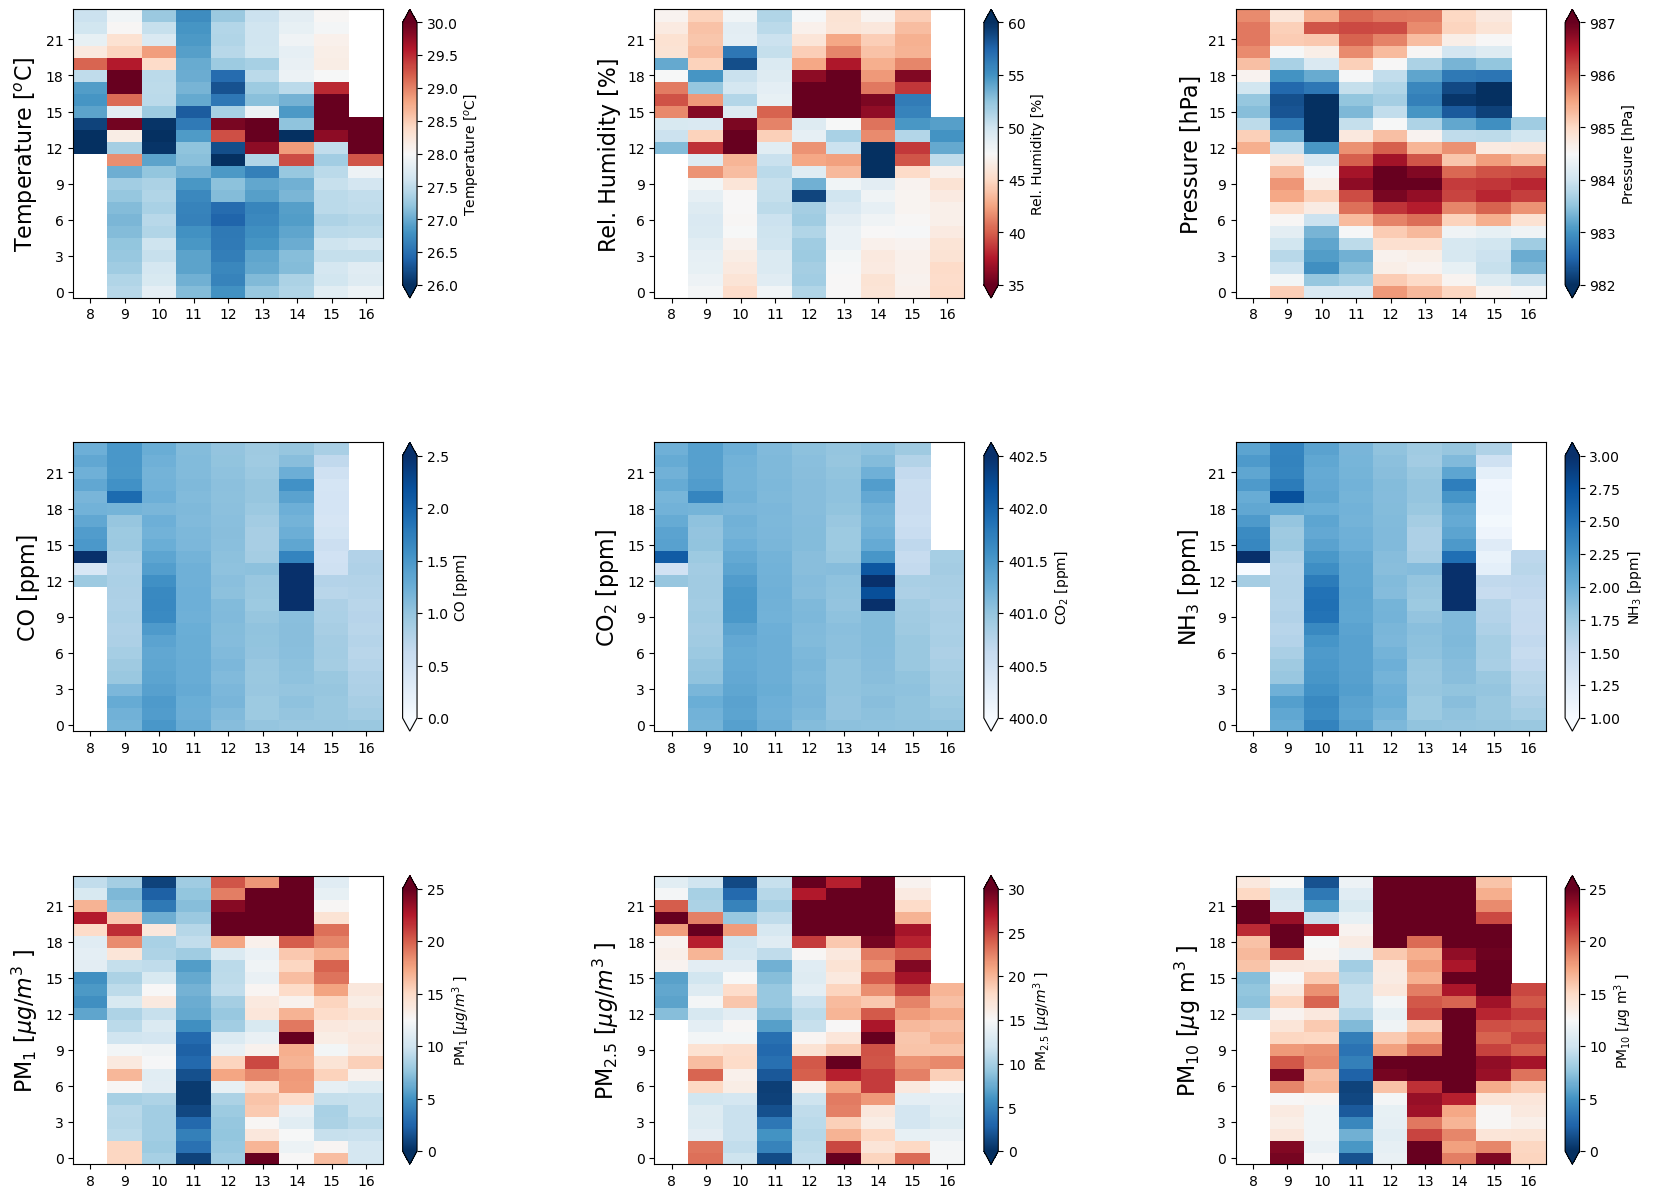

In [192]:
vmx = [30, 60, 987, 2.5, 402.5, 3, 25, 30, 25]
vmn = [26, 35, 982, 0, 400, 1, 0, 0, 0]
cmaps = ['RdBu_r','RdBu', 'RdBu_r', 'Blues', 'Blues', 'Blues', 'RdBu_r', 'RdBu_r', 'RdBu_r']#'jet_r']

cs = 3
siz = df.columns[:-2]
rs = len(siz)//cs if len(siz)%cs==0 else (len(siz)//cs)+1 
fig, axes = plt.subplots(ncols=cs, nrows=rs, figsize=(20,15))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for col, label in enumerate(siz):
    ax = axes[col//cs, col%cs]
    cb = ax.pcolor(pivot_df[label], cmap=cmaps[col], vmax=vmx[col], vmin=vmn[col])
    ax.set_ylabel(f"{quantities[col]} [{units[col]}]", fontsize=16)
    
    ax.set_yticks(np.arange(0,24,3)+.5,pivot_df.index[::3], )
    ax.set_xticks(np.arange(len(list(set(np.copy(list(pivot_df.columns)).T[1]))))+.5,sorted(np.int_(list(set(np.copy(list(pivot_df.columns)).T[1])))) )
    
    plt.colorbar(cb, label=f"{quantities[col]} [{units[col]}]", extend='both')